# Step 1: Environment Setup & Library Import

In [14]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1.1 Configuration
SEED = 42
IMAGE_SIZE = (224, 224) # Standard for EfficientNet/ResNet
BATCH_SIZE = 32
EPOCHS = 2             # We will likely stop early, but set high capacity
LEARNING_RATE = 1e-4    # Lower LR for Transfer Learning stability

# Reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.18.0
GPU Available: True


# Step 2: Dynamic Pathing & Configuration

In [15]:
# 2.1 Define Base Path
# Note: Adjust if your specific dataset version has a slightly different internal folder structure
dataset_path = '/kaggle/input/garbage-classification-v2/garbage-dataset'

# 2.2 Load Filepaths and Labels
filepaths = []
labels = []

# Crawl the directory
classes = sorted(os.listdir(dataset_path)) # ['battery', 'biological', 'cardboard', ...]

for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir): # Ensure it's a directory
        files = glob.glob(os.path.join(class_dir, '*')) # Get all files
        for f in files:
            filepaths.append(f)
            labels.append(class_name)

# 2.3 Create Master DataFrame
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

print(f"Total Images Found: {len(df)}")
print(f"Classes Found: {df['label'].unique()}")
df.head()

Total Images Found: 19762
Classes Found: ['battery' 'biological' 'cardboard' 'clothes' 'glass' 'metal' 'paper'
 'plastic' 'shoes' 'trash']


,filepath,label
0,/kaggle/input/garbage-classification-v2/garbag...,battery
1,/kaggle/input/garbage-classification-v2/garbag...,battery
2,/kaggle/input/garbage-classification-v2/garbag...,battery
3,/kaggle/input/garbage-classification-v2/garbag...,battery
4,/kaggle/input/garbage-classification-v2/garbag...,battery


# Step 3: Exploratory Data Analysis (EDA)

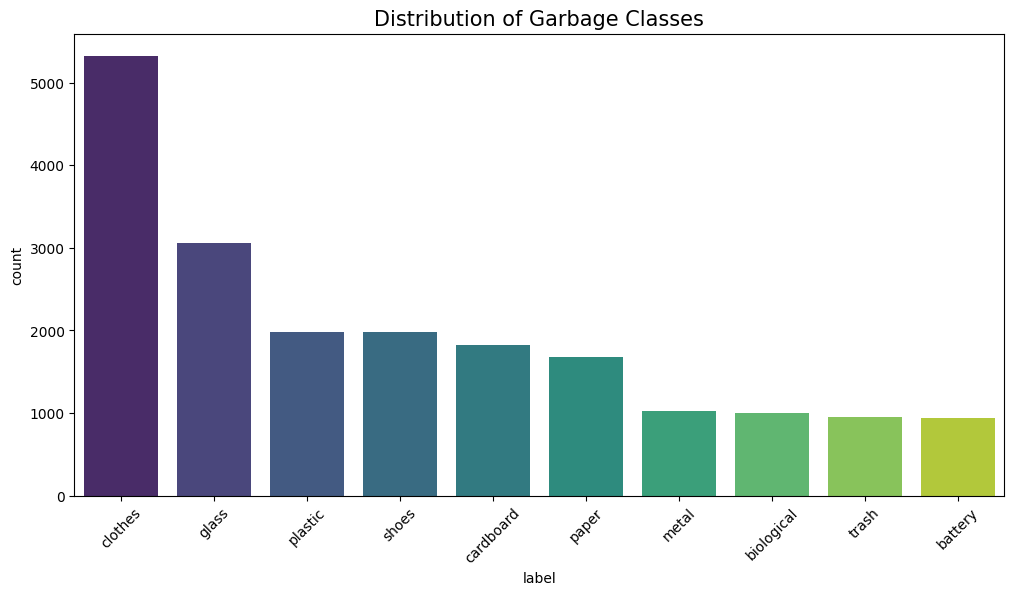

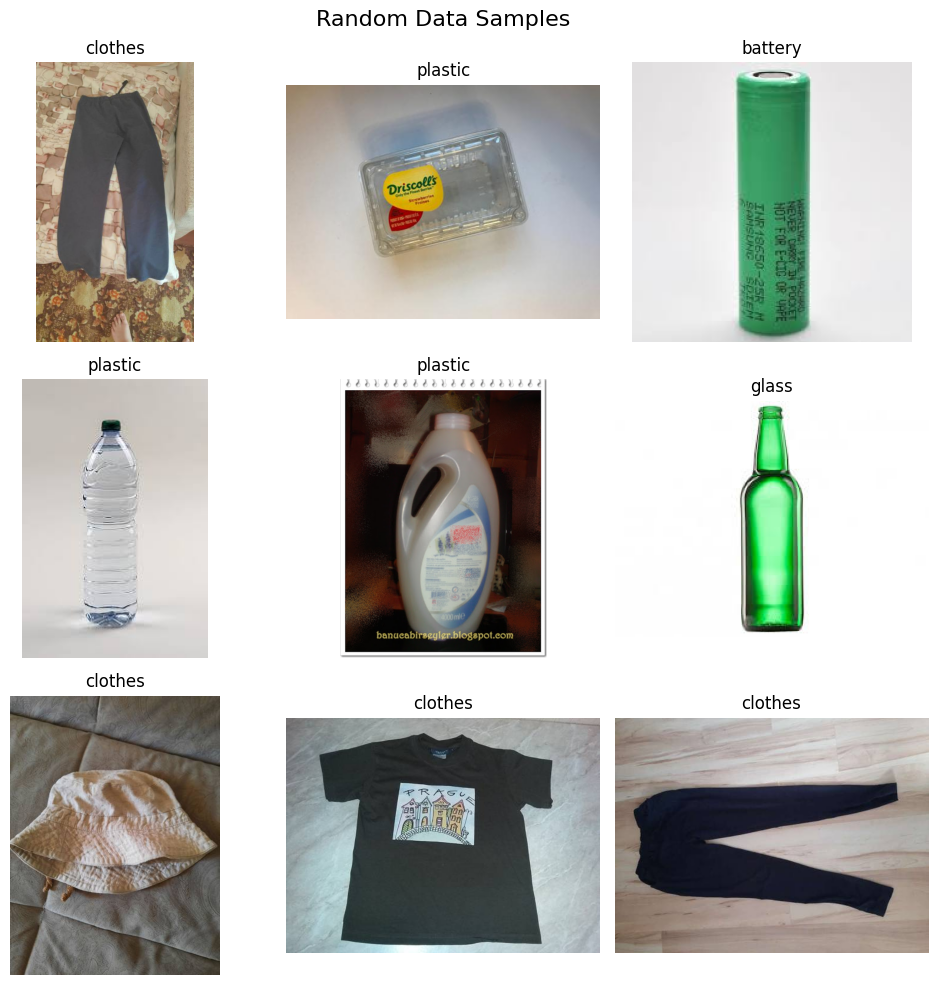

In [18]:
# 3.1 Class Distribution Analysis
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', palette='viridis', order=df['label'].value_counts().index)
plt.title('Distribution of Garbage Classes', fontsize=15)
plt.xticks(rotation=45)
plt.show()

# 3.2 Visual Inspection of Samples
# It is critical to verify that images are not corrupt
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
sample_df = df.sample(9)

for i, (idx, row) in enumerate(sample_df.iterrows()):
    ax = axes[i // 3, i % 3]
    img = plt.imread(row['filepath'])
    ax.imshow(img)
    ax.set_title(row['label'])
    ax.axis('off')
plt.suptitle("Random Data Samples", fontsize=16)
plt.tight_layout()
plt.show()

# Step 4: Data Pipeline & Robust Preprocessing

In [19]:
# 4.1 Stratified Split (80% Train, 10% Val, 10% Test)
# First split: 80% Train, 20% Temp
train_df, temp_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=SEED, stratify=df['label'])

# Second split: Split the 20% Temp into equal Val and Test (10% each of total)
val_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=SEED, stratify=temp_df['label'])

print(f"Training Set: {len(train_df)} images")
print(f"Validation Set: {len(val_df)} images")
print(f"Test Set: {len(test_df)} images")

# 4.2 Data Generators with Augmentation
# We use MobileNet/EfficientNet preprocessing function for optimal convergence
from tensorflow.keras.applications.efficientnet import preprocess_input

# Generator for Training (With Augmentation)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,      # Rotates image
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2, # Vertical shift
    shear_range=0.2,        # Shearing
    zoom_range=0.2,         # Zooming
    horizontal_flip=True,   # Flipping
    fill_mode='nearest'     # Handling new pixels
)

# Generator for Validation/Test (NO Augmentation - simply rescale/preprocess)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# 4.3 Flow from DataFrame
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Crucial for correct evaluation later
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Crucial for confusion matrix mapping
)

Training Set: 15809 images
Validation Set: 1976 images
Test Set: 1977 images
Found 15809 validated image filenames belonging to 10 classes.
Found 1976 validated image filenames belonging to 10 classes.
Found 1977 validated image filenames belonging to 10 classes.


# Step 5: Model Architecture

In [20]:
# 5.1 Calculate Class Weights to handle imbalance
from sklearn.utils import class_weight

# We extract labels from the training data generator to compute weights
train_labels = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to dictionary format required by Keras
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights calculated:")
for i, weight in class_weights_dict.items():
    print(f"Class {list(train_gen.class_indices.keys())[i]}: {weight:.2f}")

# 5.2 Build the Model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, # Drop the ImageNet classifier at the top
    weights='imagenet', # Use learned features
    input_shape=(224, 224, 3)
)

# Freeze the base model initially (We train only the new head first)
base_model.trainable = False

# Create the new head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False) 
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Flatten 
x = tf.keras.layers.BatchNormalization()(x)      # Stabilize training
x = tf.keras.layers.Dropout(0.2)(x)              # Prevent overfitting
outputs = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# 5.3 Compile the Model
# We track Precision and Recall live during training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

model.summary()

Class Weights calculated:
Class battery: 2.09
Class biological: 1.98
Class cardboard: 1.08
Class clothes: 0.37
Class glass: 0.65
Class metal: 1.94
Class paper: 1.18
Class plastic: 1.00
Class shoes: 1.00
Class trash: 2.09
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,067,501 (15.52 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

# Step 6: Training with Callbacks

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Stop if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# Reduce Learning Rate if accuracy stagnates (helps descend into the minimum)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # Multiply LR by 0.2
    patience=3, 
    min_lr=1e-6,
    verbose=1
)

# Save the absolute best model based on Validation Accuracy
checkpoint = ModelCheckpoint(
    'best_garbage_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

# Step 7: Training

In [23]:
history = model.fit(
    train_gen,
    epochs=10, 
    validation_data=val_gen,
    class_weight=class_weights_dict, # CRITICAL: Fixes the class imbalance
    callbacks=callbacks
)

Epoch 1/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9033 - loss: 0.3105 - precision: 0.9251 - recall: 0.8857
Epoch 1: val_accuracy improved from 0.92561 to 0.93067, saving model to best_garbage_model.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 281s 568ms/step - accuracy: 0.9033 - loss: 0.3105 - precision: 0.9251 - recall: 0.8857 - val_accuracy: 0.9307 - val_loss: 0.2356 - val_precision: 0.9456 - val_recall: 0.9236 - learning_rate: 1.0000e-04
Epoch 2/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9105 - loss: 0.3049 - precision: 0.9294 - recall: 0.8924
Epoch 2: val_accuracy did not improve from 0.93067
495/495 ━━━━━━━━━━━━━━━━━━━━ 252s 509ms/step - accuracy: 0.9105 - loss: 0.3049 - precision: 0.9294 - recall: 0.8924 - val_accuracy: 0.9297 - val_loss: 0.2324 - val_precision: 0.9426 - val_recall: 0.9226 - learning_rate: 1.0000e-04
Epoch 3/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9086 - loss: 0.2923 - precision: 0.9272 - recall: 0.8916
Epoch 3: val_ac

In [24]:
# Unfreeze the base model
base_model.trainable = True

# It's critical to recompile with a VERY LOW learning rate to avoid destroying learned weights
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 10x smaller LR
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

print("Starting Fine-Tuning...")

history_fine = model.fit(
    train_gen,
    epochs=5, # Add 5 more epochs
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Starting Fine-Tuning...
Epoch 1/5


E0000 00:00:1764783290.463071     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764783290.652925     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764783291.140441     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764783291.347282     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764783291.718703     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

  2/495 ━━━━━━━━━━━━━━━━━━━━ 54s 111ms/step - accuracy: 0.7344 - loss: 0.8792 - precision: 0.8407 - recall: 0.7031  

E0000 00:00:1764783321.407793     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764783321.595928     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.7385 - loss: 0.7619 - precision: 0.8159 - recall: 0.6786
Epoch 1: val_accuracy did not improve from 0.93877
495/495 ━━━━━━━━━━━━━━━━━━━━ 319s 504ms/step - accuracy: 0.7385 - loss: 0.7617 - precision: 0.8159 - recall: 0.6787 - val_accuracy: 0.8866 - val_loss: 0.3842 - val_precision: 0.9247 - val_recall: 0.8634 - learning_rate: 1.0000e-05
Epoch 2/5
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8385 - loss: 0.4923 - precision: 0.8875 - recall: 0.7987
Epoch 2: val_accuracy did not improve from 0.93877
495/495 ━━━━━━━━━━━━━━━━━━━━ 217s 439ms/step - accuracy: 0.8385 - loss: 0.4923 - precision: 0.8875 - recall: 0.7987 - val_accuracy: 0.9008 - val_loss: 0.3648 - val_precision: 0.9284 - val_recall: 0.8796 - learning_rate: 1.0000e-05
Epoch 3/5
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8691 - loss: 0.4034 - precision: 0.9019 - recall: 0.8348
Epoch 3: val_accuracy did not improve from 0.93877
495/495 ━━━━━━━━━━━━━━━

# Step 8: Evaluation

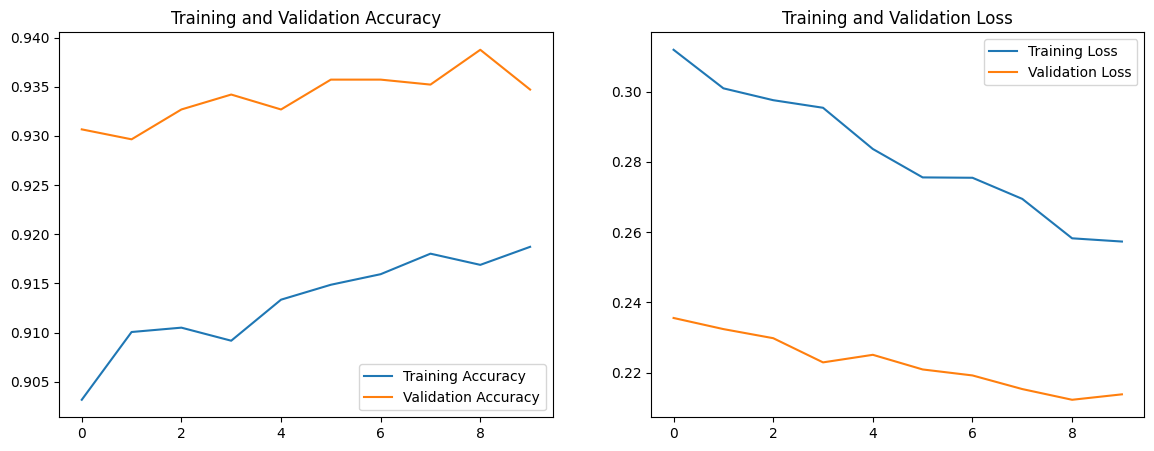

Evaluating on Test Set...
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9357 - loss: 0.2312 - precision: 0.9480 - recall: 0.9209

Test Accuracy: 92.87%
Test F1 Score (Approx): 0.9288
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step

Classification Report:

              precision    recall  f1-score   support

     battery       0.94      0.93      0.93        94
  biological       0.92      0.98      0.95       100
   cardboard       0.92      0.90      0.91       183
     clothes       0.99      0.96      0.97       533
       glass       0.96      0.89      0.92       306
       metal       0.76      0.90      0.83       102
       paper       0.88      0.93      0.90       168
     plastic       0.90      0.90      0.90       199
       shoes       0.94      0.95      0.95       198
       trash       0.85      0.91      0.88        94

    accuracy                           0.93      1977
   macro avg       0.91      0.93      0.92      1977
weighted avg       0.93      0.93   

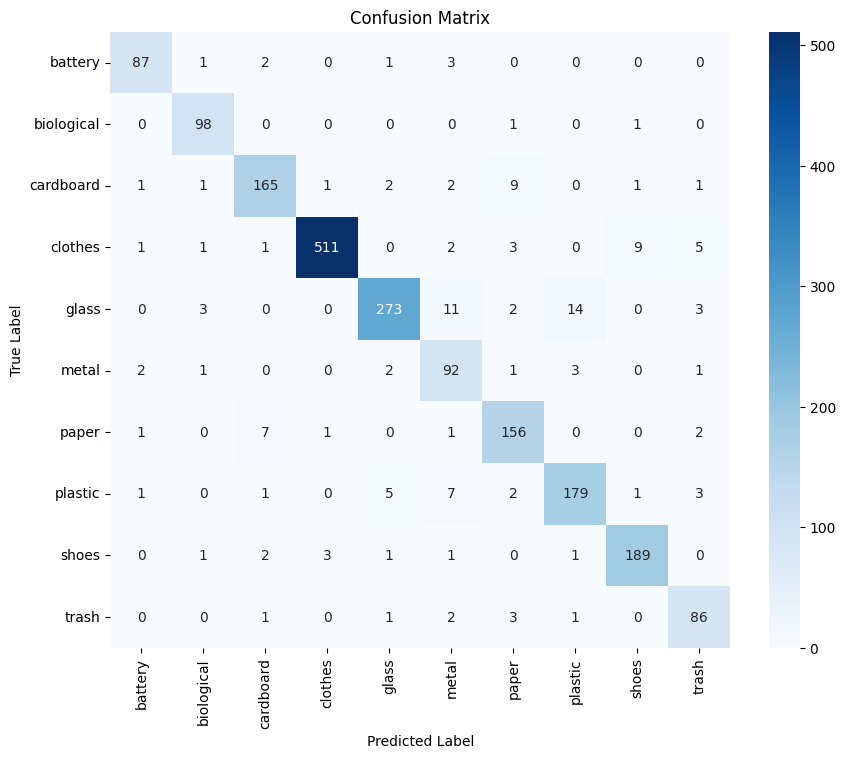

In [25]:
# 8.1 Visualize Training History
# We plot Loss and Accuracy to verify convergence
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 8.2 Evaluate on Test Set (The "Final Exam")
print("Evaluating on Test Set...")
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test F1 Score (Approx): {2*((test_precision*test_recall)/(test_precision+test_recall + 1e-7)):.4f}")

# 8.3 Detailed Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
# Note: specific to ImageDataGenerator, we must reset to ensure order matches
test_gen.reset()
predictions = model.predict(test_gen, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Print per-class metrics
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 9: Real-World Inference System

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


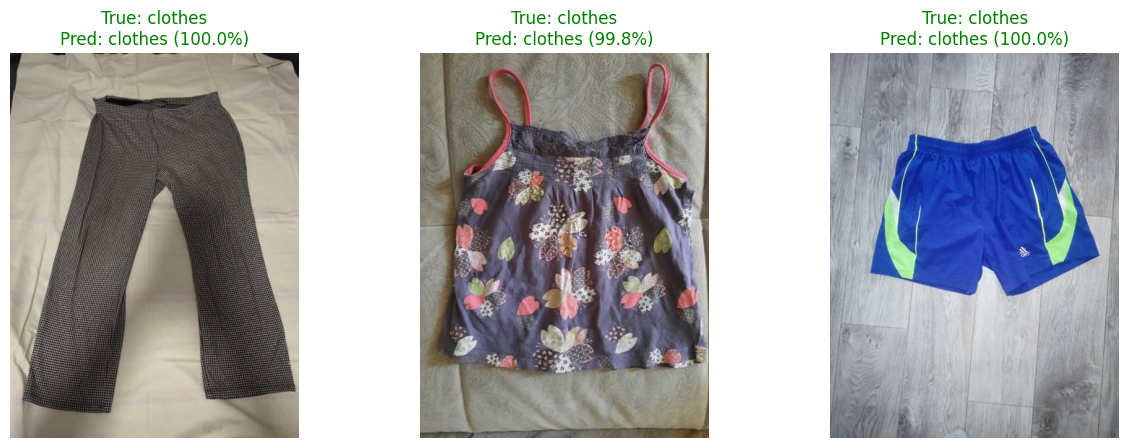

In [26]:
from tensorflow.keras.preprocessing import image

def predict_garbage(image_path, model, class_labels):
    """
    Loads an image, preprocesses it, and predicts the class.
    """
    # Load and resize
    img = image.load_img(image_path, target_size=IMAGE_SIZE)
    
    # Convert to array and preprocess (Same as training!)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    
    # Predict
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = 100 * np.max(predictions)
    
    return predicted_class, confidence, img

# 9.1 Test on Random Samples from Test Set
import random

# Get 3 random images from the test dataframe
random_samples = test_df.sample(3)

plt.figure(figsize=(15, 5))

for i, (index, row) in enumerate(random_samples.iterrows()):
    path = row['filepath']
    true_label = row['label']
    
    pred_label, conf, img_data = predict_garbage(path, model, class_labels)
    
    # Display
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(image.load_img(path)) # Show original image
    
    # Color code title: Green if correct, Red if wrong
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label} ({conf:.1f}%)", color=color, fontsize=12)
    plt.axis('off')

plt.show()

# Step 10: Saving the model

In [27]:
# Save in Keras native format
model.save('garbage_classifier_efficientnet.keras')
print("Model saved successfully.")

Model saved successfully.
